In [1]:
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from src.output import Output_uc

In [2]:
num_units = 8
num_periods = 600
demand_start = 800

In [3]:
demand = np.arange(demand_start, demand_start + num_periods + 1, 1)
reserve = np.tile(np.array([250]), reps=num_periods)
renewable = np.tile(np.array([0]), reps=num_periods)

p_min = np.ones((num_units))
p_max = np.array([250, 230, 250, 240, 230, 210, 240, 250])
ramp_up = p_max.copy()
ramp_down = p_max.copy()
startup_ramp = p_max.copy()
shutdown_ramp = p_max.copy()
min_up = np.array([0, 0, 0, 0, 0, 0, 0, 0])
min_down = np.array([0, 0, 0, 0, 0, 0, 0, 0])

cost_lin = np.array([2, 17, 17.5, 18, 18.5, 19, 20, 28])
cost_const = np.ones((num_units))

cost_startup_step_formulation_1 = np.array([[0], [0], [0], [0], [0], [0], [0], [0]])
step_length_formulation_1 = np.array([[0], [0], [0], [0], [0], [0], [0], [0]])

u_prev = np.array([0, 0, 0, 0, 0, 0, 0, 0])
p_tight_prev = np.array([0, 0, 0, 0, 0, 0, 0, 0]) - p_min * u_prev
min_up_r = np.array([0, 0, 0, 0, 0, 0, 0, 0, ])
min_down_r = np.array([0, 0, 0, 0, 0, 0, 0, 0, ])
min_down_0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, ])

In [4]:
reserve = demand * 0.3

In [5]:
from src.input import Input_uc


input_uc = Input_uc(
    unit_type=np.arange(num_units),
    idx_nuclear=np.array([0]),
    idx_coal=np.array([1, 2, 3]),
    idx_lng=np.array([4, 5, 6]),
    idx_lmao=np.array([7]),
    num_units=num_units,
    num_periods=num_periods,
    #########################
    demand=demand,
    reserve=reserve,
    renewable=renewable,
    #########################
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    #########################
    cost_lin=cost_lin,
    cost_const=cost_const,
    #########################
    cost_startup_step_formulation_0=0,
    num_cooling_steps_formulation_0=0,
    cost_startup_step_formulation_1=cost_startup_step_formulation_1,
    step_length_formulation_1=step_length_formulation_1,
    #########################
    p_prev=0,
    u_prev=u_prev,
    min_up_r=min_up_r,
    min_down_r=min_down_r,
    min_up_0=0,
    min_down_0=min_down_0,
)

TypeError: Input_uc.__init__() got an unexpected keyword argument 'idx_lmao'

In [ ]:
### ATTRIBUTE LOCALIZATION & GUROBIPY-FRIENDLY TYPE CONVERSION
# meta
num_units = num_units
num_periods = num_periods
# system
demand = demand.tolist()
reserve = reserve.tolist()
renewable = renewable.tolist()
# generator
p_min = p_min.tolist()
p_max = p_max.tolist()
ramp_up = ramp_up.tolist()
ramp_down = ramp_down.tolist()
startup_ramp = startup_ramp.tolist()
shutdown_ramp = shutdown_ramp.tolist()
min_up = min_up.tolist()
min_down = min_down.tolist()
# cost function - generation
cost_lin = cost_lin.tolist()
cost_const = cost_const.tolist()
# cost function - startup
cost_startup_step_formulation_1 = cost_startup_step_formulation_1.tolist()
step_length_formulation_1 = step_length_formulation_1.tolist()
# initial conditions
p_tight_prev = p_tight_prev.tolist()
u_prev = u_prev.tolist()
min_up_r = min_up_r.tolist()
min_down_r = min_down_r.tolist()
min_down_0 = min_down_0.tolist()

In [ ]:
_is_inside_iter = False
output_uc = None

In [ ]:
### MODEL DECLARATION
model = gp.Model() # below param can ensure better (smaller) objval than no param. the change in objval from default is >0.01% though
model.setParam("OutputFlag", 1)
model.setParam("Symmetry", 2) # okay but its 100% safe at least
model.setParam("PreDual", 2) # 100% safe and v good
model.setParam("Presolve", 1) # speed boost v good but obj value increase; this is eaten up by the others
model.setParam("PreSparsify", 2) # v good with objval decrease
model.setParam("Disconnected", 2) # okay and 100% safe at least
model.setParam("Heuristics", 1) # good probably idk at this point; gambling its good 51% times (in speed); objval improvement 100% + feasibility
model.setParam("ProjImpliedCuts", 2) # gambling 77% ; extremely v good for only large reserve big problem

ub_pseudo = np.tile(np.array(np.array(p_max) - np.array(p_min))[:, None], reps=num_periods)

p_tight = model.addVars(range(num_units), range(num_periods), lb=0, ub=ub_pseudo.tolist())
r = model.addVars(range(num_units), range(num_periods), lb=0, ub=np.tile(np.array([0, 160, 100, 130, 60, 130, 190, 0])[:, None], reps=num_periods))
if not _is_inside_iter:
    u = model.addVars(range(num_units), range(num_periods), vtype=gp.GRB.BINARY)
    # v = model.addVars(range(num_units), range(num_periods), vtype=gp.GRB.BINARY)
    # w = model.addVars(range(num_units), range(num_periods), vtype=gp.GRB.BINARY)
    # delta = model.addVars(range(num_units), range(num_periods), range(3), vtype=gp.GRB.BINARY)
else:
    u = gp.tupledict({(i, t): int(output_uc.u[i, t]) for i in range(num_units) for t in range(num_periods)})
    # v = gp.tupledict({(i, t): int(output_uc.v[i, t]) for i in range(num_units) for t in range(num_periods)})
    # w = gp.tupledict({(i, t): int(output_uc.w[i, t]) for i in range(num_units) for t in range(num_periods)})
    # delta = gp.tupledict({(i, t, s): int(output_uc.delta[i, t, s]) for i in range(num_units) for t in range(num_periods) for s in range(3)})

def p_tight_minus_proof(i, t_):
    return p_tight[i, t_] if t_ >= 0 else p_tight_prev[i]
def u_minus_proof(i, t_):
    return u[i, t_] if t_ >= 0 else u_prev[i][t_]
# helper - startup cost indices precomputation
T_SU = []
for i in range(num_units):
    starts = [min_down_0[i]]
    for L in step_length_formulation_1[i][:-1]:
        starts.append(starts[-1] + L)
    T_SU.append(starts)

model.addConstrs(
    p_tight[i, t]
    <=
    u[i, t] * (p_max[i] - p_min[i])
    for i in range(num_units)
    for t in range(num_periods)
)
model.addConstrs(
    p_tight[i, t] + r[i, t]
    <=
    u[i, t] * (p_max[i] - p_min[i])
    for i in range(num_units)
    for t in range(num_periods)
)
constr_generation = model.addConstrs(
    gp.quicksum(
        u[i, t] * p_min[i] 
        +
        p_tight[i, t]
        for i in range(num_units)
    )
    + renewable[t]
    ==
    demand[t]
    for t in range(num_periods)
)
if not _is_inside_iter:
    constr_reserve = model.addConstrs(
        gp.quicksum(
            r[i, t]
            for i in range(num_units)
        )
        >=
        reserve[t]
        for t in range(num_periods)
    )
else:
    output_uc_reserve = output_uc.reserve.tolist()
    constr_reserve = model.addConstrs(
        gp.quicksum(
            r[i, t]
            for i in range(num_units)
        )
        ==
        output_uc_reserve[t]
        for t in range(num_periods)
    )
total_cost_generation = gp.quicksum(
    cost_lin[i] * (p_tight[i, t] + p_min[i] * u[i, t]) 
    + cost_const[i] * u[i, t]
    for i in range(num_units)
    for t in range(num_periods)
)
model.setObjective(total_cost_generation, gp.GRB.MINIMIZE)
model.optimize()

Set parameter Username
Set parameter LicenseID to value 2659802
Academic license - for non-commercial use only - expires 2026-05-01
Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 10800 rows, 14400 columns and 38400 nonzeros
Model fingerprint: 0xc6ea0ae0
Variable types: 9600 continuous, 4800 integer (4800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Obj

In [ ]:
output_uc = Output_uc()
p_tight = np.array(model.getAttr("X", p_tight).select()).reshape(num_units, num_periods)

output_uc.u = np.array(model.getAttr("X", u).select()).reshape(num_units, num_periods).astype(np.int64)
output_uc.p = (output_uc.u.transpose() * p_min + p_tight.transpose()).transpose()
output_uc.r = np.array(model.getAttr("X", r).select()).reshape(num_units, num_periods)
output_uc.reserve = output_uc.r.sum(axis=0)

In [ ]:
_is_inside_iter = True

In [ ]:
### MODEL DECLARATION
model = gp.Model() # below param can ensure better (smaller) objval than no param. the change in objval from default is >0.01% though
model.setParam("OutputFlag", 1)
model.setParam("Symmetry", 2) # okay but its 100% safe at least
model.setParam("PreDual", 2) # 100% safe and v good
model.setParam("Presolve", 1) # speed boost v good but obj value increase; this is eaten up by the others
model.setParam("PreSparsify", 2) # v good with objval decrease
model.setParam("Disconnected", 2) # okay and 100% safe at least
model.setParam("Heuristics", 1) # good probably idk at this point; gambling its good 51% times (in speed); objval improvement 100% + feasibility
model.setParam("ProjImpliedCuts", 2) # gambling 77% ; extremely v good for only large reserve big problem

ub_pseudo = np.tile(np.array(np.array(p_max) - np.array(p_min))[:, None], reps=num_periods)

p_tight = model.addVars(range(num_units), range(num_periods), lb=0, ub=ub_pseudo.tolist())
r = model.addVars(range(num_units), range(num_periods), lb=0, ub=np.tile(np.array([0, 160, 100, 130, 60, 130, 190, 0])[:, None], reps=num_periods))
if not _is_inside_iter:
    u = model.addVars(range(num_units), range(num_periods), vtype=gp.GRB.BINARY)
    # v = model.addVars(range(num_units), range(num_periods), vtype=gp.GRB.BINARY)
    # w = model.addVars(range(num_units), range(num_periods), vtype=gp.GRB.BINARY)
    # delta = model.addVars(range(num_units), range(num_periods), range(3), vtype=gp.GRB.BINARY)
else:
    u = gp.tupledict({(i, t): int(output_uc.u[i, t]) for i in range(num_units) for t in range(num_periods)})
    # v = gp.tupledict({(i, t): int(output_uc.v[i, t]) for i in range(num_units) for t in range(num_periods)})
    # w = gp.tupledict({(i, t): int(output_uc.w[i, t]) for i in range(num_units) for t in range(num_periods)})
    # delta = gp.tupledict({(i, t, s): int(output_uc.delta[i, t, s]) for i in range(num_units) for t in range(num_periods) for s in range(3)})

def p_tight_minus_proof(i, t_):
    return p_tight[i, t_] if t_ >= 0 else p_tight_prev[i]
def u_minus_proof(i, t_):
    return u[i, t_] if t_ >= 0 else u_prev[i][t_]
# helper - startup cost indices precomputation
T_SU = []
for i in range(num_units):
    starts = [min_down_0[i]]
    for L in step_length_formulation_1[i][:-1]:
        starts.append(starts[-1] + L)
    T_SU.append(starts)

model.addConstrs(
    p_tight[i, t]
    <=
    u[i, t] * (p_max[i] - p_min[i])
    for i in range(num_units)
    for t in range(num_periods)
)
model.addConstrs(
    p_tight[i, t] + r[i, t]
    <=
    u[i, t] * (p_max[i] - p_min[i])
    for i in range(num_units)
    for t in range(num_periods)
)
constr_generation = model.addConstrs(
    gp.quicksum(
        u[i, t] * p_min[i] 
        +
        p_tight[i, t]
        for i in range(num_units)
    )
    + renewable[t]
    ==
    demand[t]
    for t in range(num_periods)
)
if not _is_inside_iter:
    constr_reserve = model.addConstrs(
        gp.quicksum(
            r[i, t]
            for i in range(num_units)
        )
        >=
        reserve[t]
        for t in range(num_periods)
    )
else:
    output_uc_reserve = output_uc.reserve.tolist()
    constr_reserve = model.addConstrs(
        gp.quicksum(
            r[i, t]
            for i in range(num_units)
        )
        ==
        output_uc_reserve[t]
        for t in range(num_periods)
    )
total_cost_generation = gp.quicksum(
    cost_lin[i] * (p_tight[i, t] + p_min[i] * u[i, t]) 
    + cost_const[i] * u[i, t]
    for i in range(num_units)
    for t in range(num_periods)
)
model.setObjective(total_cost_generation, gp.GRB.MINIMIZE)
model.optimize()

Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 10800 rows, 9600 columns and 24000 nonzeros
Model fingerprint: 0x80eec4d8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 3e+01]
  Bounds range     [6e+01, 2e+02]
  RHS range        [2e+02, 1e+03]
Presolve removed 6269 rows and 2208 columns
Presolve time: 0.01s
Presolved: 4531 rows, 7392 colu

In [ ]:
output_uc.marginal_price_generation = np.array([constr_generation[t].Pi for t in range(num_periods)])
output_uc.marginal_price_reserve = np.array([constr_reserve[t].Pi for t in range(num_periods)])

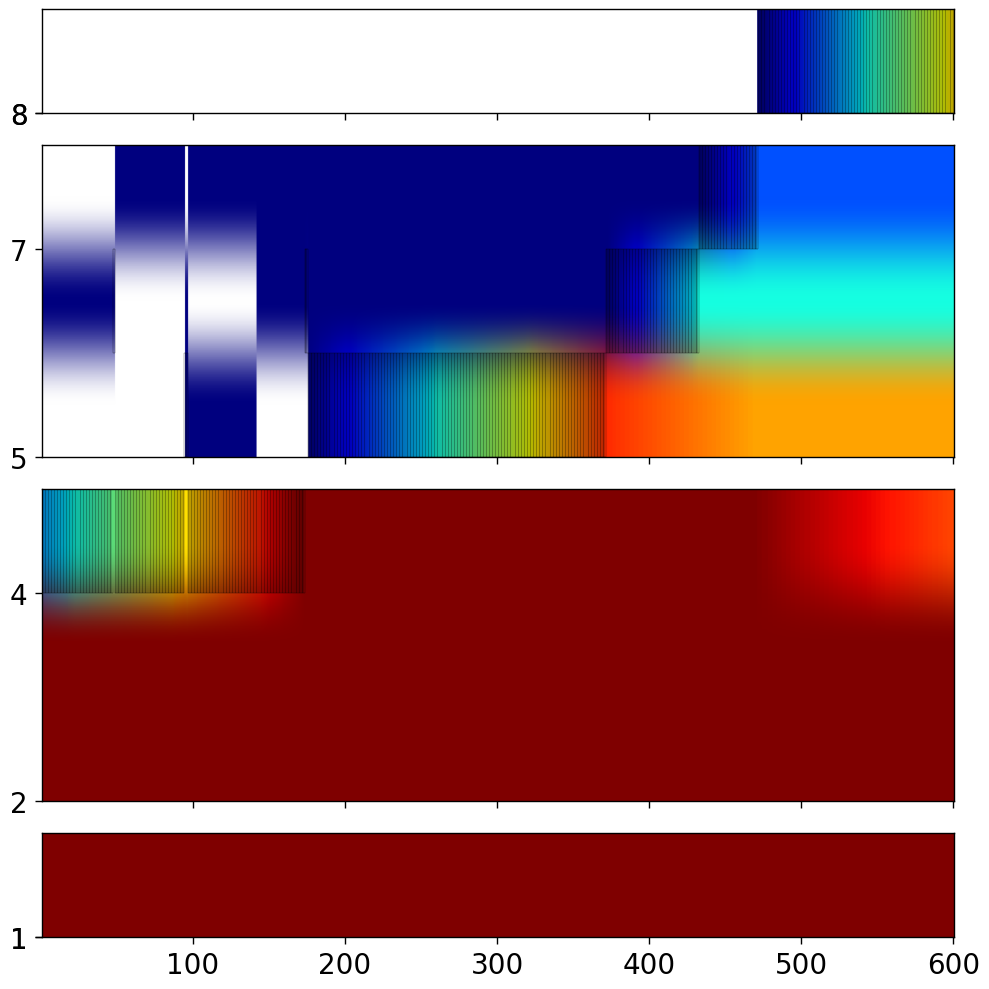

In [ ]:
fig_height = 10
cmap = plt.cm.jet.copy()
cmap.set_bad(color="white")
num_periods = output_uc.p.shape[1]

idx_marginal_unit_per_period = np.array([
    int(np.where(input_uc.cost_lin == mpg)[0][0]) 
    if mpg > 0 else -2 # for test (demand = 0 to blackstart) result plot purpose
    for mpg in output_uc.marginal_price_generation
    ])

helper = [
    (input_uc.idx_lmao, 7),
    (input_uc.idx_lng, 4),
    (input_uc.idx_coal, 1),
    (input_uc.idx_nuclear, 0),
]

fig, axes = plt.subplots(4, 1, figsize=(fig_height, fig_height), gridspec_kw={"height_ratios": [1/8, 3/8, 3/8, 1/8]}, sharex=True)

for ax, (idx_type, idx_start) in zip(axes, helper):
    p_type = output_uc.p[idx_type]
    num_units_type = len(p_type)
    p_min_type = np.tile(input_uc.p_min[idx_type][:, None], reps=num_periods)
    p_max_type = np.tile(input_uc.p_max[idx_type][:, None], reps=num_periods)
    heatmap = (p_type - p_min_type) / (p_max_type - p_min_type) * 100
    heatmap[p_type == 0] = np.nan

    #
    ax.imshow(
        heatmap,
        aspect="auto",
        origin="lower",
        extent=[0.5, input_uc.num_periods + 0.5, idx_start, idx_start + num_units_type],
        cmap=cmap,
        vmin=0,
        vmax=100,
    )
    
    #
    pad_rectangle = 0
    pad_rectangle = 0.066 / 20 * fig_height if pad_rectangle is None else pad_rectangle
    for t in range(num_periods):
        u_abs = idx_marginal_unit_per_period[t]
        if idx_start <= u_abs < idx_start + num_units_type:

            # rect_h = Rectangle(
            #     (t + 0.5 + pad_rectangle, u_abs), 1 - 2 * pad_rectangle, 1,
            #     fill=False,
            #     edgecolor="white",
            #     facecolor="none",
            #     hatch="///",
            #     linewidth=0,
            #     zorder=3
            # )
            # rect_h.set_hatch_linewidth(fig_height / 10)
            # ax.add_patch(rect_h)

            ax.add_patch(
                Rectangle(
                    (t + 0.5 + pad_rectangle, u_abs), 1 - 2 * pad_rectangle, 1,
                    fill=False,
                    edgecolor="black",
                    facecolor="none",
                    # hatch="//",
                    linewidth=fig_height / 50,
                    zorder=3
                )
            )

    #
    ax.set_yticks([idx_start, idx_start + num_units_type - 1])
    ax.set_yticklabels([idx_start + 1, idx_start + num_units_type])
    ax.tick_params(axis="both", width=fig_height / 10, length=fig_height / 2, pad=fig_height / 2, labelsize=fig_height * 2)
    for side in ["bottom", "left", "top", "right"]:
        ax.spines[side].set_linewidth(fig_height / 10)

if num_periods == 24:
    axes[-1].set_xticks([1, 6, 12, 18, 24])
    axes[-1].set_xticklabels([1, 6, 12, 18, 24])

# axes[-2].hlines(y=57, xmin=1, xmax=24, colors="black", ls="--") # for TA: you can test like this the 57th (0-based) idx unit will be shown

ax.tick_params(axis="x", which="minor",
    width=fig_height / 10, length=fig_height / 2, pad=fig_height / 2, labelsize=0)



plt.tight_layout()
plt.show(fig)

In [ ]:
idx = 420
output_uc.marginal_price_reserve[idx], output_uc.marginal_price_generation[idx]

(np.float64(0.5), np.float64(19.0))